# Homework 1

## Gradient boosting on temporal data and feature importances

Here we will work with widely known Human Actividy Recognition (HAR) dataset. Data is available at [UCI repository](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones).

There are available both raw and preprocessed datasets. This time we will use the preprocessed one.

Today we will work with [LightGBM](https://github.com/Microsoft/LightGBM) by Microsoft. It is one of the most popular frameworks these days that shows both great quality and performance.

There are another great frameworks (listed below). However, we will stick to `LightGBM` for this task.

* [Catboost](https://github.com/catboost/catboost) by Yandex. Novel framework by Yandex company tuned to deal well with categorical features.
* [xgboost](https://github.com/dmlc/xgboost) by dlmc. The most famous framework which got very popular on kaggle.

Some simple preprocessing is done for you. 

Your __ultimate target is to get familiar with one of the frameworks above__ and achieve at least 90% accuracy on test dataset and try to get some useful insights on the features the model paid attention to.

__Please, use [`shap`](https://github.com/slundberg/shap) and interpret the generated plots (with a brief summary).__

_Despite the main language of this notebook is English, feel free to write your thoughts in Russian._

## Part 0. Downloading and preprocessing

The preprocessing is done for you. Let's take a look at the data:

In [44]:
# Download and unpack dataset from UCI
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
!unzip -u "UCI HAR Dataset.zip" "UCI HAR Dataset/train/X_train.txt" "UCI HAR Dataset/train/y_train.txt" \
"UCI HAR Dataset/test/X_test.txt" "UCI HAR Dataset/test/y_test.txt" "UCI HAR Dataset/activity_labels.txt"

File ‘UCI HAR Dataset.zip’ already there; not retrieving.

Archive:  UCI HAR Dataset.zip


In [45]:
import matplotlib.pyplot as plt
import numpy as np

In [46]:
X_train = np.genfromtxt("UCI HAR Dataset/train/X_train.txt")
y_train = np.genfromtxt("UCI HAR Dataset/train/y_train.txt")
print(f"Train set: {X_train.shape}, {y_train.shape}")

X_test = np.genfromtxt("UCI HAR Dataset/test/X_test.txt")
y_test = np.genfromtxt("UCI HAR Dataset/test/y_test.txt")
print(f"Test set: {X_test.shape}, {y_test.shape}")

n_features = X_train.shape[1]

Train set: (7352, 561), (7352,)
Test set: (2947, 561), (2947,)


In [47]:
activity_labels = {}
with open("UCI HAR Dataset/activity_labels.txt", "r") as file:
    for i, line in enumerate(file):
        name = line.strip().split(" ")[1]
        activity_labels[i] = name

activity_labels

{0: 'WALKING',
 1: 'WALKING_UPSTAIRS',
 2: 'WALKING_DOWNSTAIRS',
 3: 'SITTING',
 4: 'STANDING',
 5: 'LAYING'}

Let's normalize data

In [48]:
data_mean = X_train.mean(axis=0)
data_std = X_train.std(axis=0)

X_train = (X_train - data_mean) / data_std
X_test = (X_test - data_mean) / data_std

The dataset has some duplicating features. Let's remove them

In [49]:
# fmt: off
duplicating_columns = (
    205, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 231, 244, 257, 507, 520, 533, 546,
)
# fmt: on

duplicating_mask = np.isin(range(n_features), duplicating_columns)

In [50]:
X_train_unique = X_train[:, ~duplicating_mask]
X_test_unique = X_test[:, ~duplicating_mask]

X_train_unique.shape, X_test_unique.shape

((7352, 540), (2947, 540))

In [51]:
y_test = np.array([item - 1 for item in y_test])
y_train = np.array([item - 1 for item in y_train])

PCA could be useful in this case. E.g.

In [52]:
from sklearn.decomposition import PCA

In [53]:
pca = PCA(0.99)

X_train_pca = pca.fit_transform(X_train_unique)
X_test_pca = pca.transform(X_test_unique)

X_train_pca.shape, X_test_pca.shape

((7352, 179), (2947, 179))

Text(0, 0.5, 'Principal component 2')

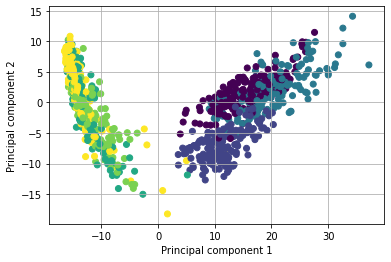

In [54]:
plt.scatter(X_train_pca[:1000, 0], X_train_pca[:1000, 1], c=y_train[:1000])
plt.grid()
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")

Text(0, 0.5, 'Principal component 5')

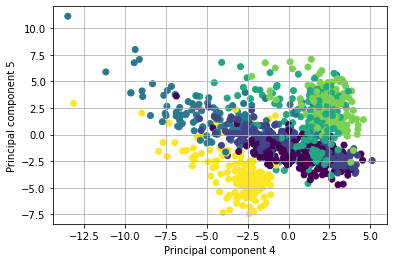

In [55]:
plt.scatter(X_train_pca[:1000, 3], X_train_pca[:1000, 4], c=y_train[:1000])
plt.grid()
plt.xlabel("Principal component 4")
plt.ylabel("Principal component 5")

## Part 1. Fit the model.

Despite optimal parameters (e.g. for xgboost) can be found on the web, we still want you to approximate them by yourself.

In this part just check some (3-5) sets of hyperparameters by hand.

In [56]:
# YOUR CODE HERE
!pip install optuna --quiet
# Example: https://rpubs.com/burakh/har_xgb

## Part 2. Use hyper parameter tuning system

Use [optuna](https://optuna.org/), [hyperopt](http://hyperopt.github.io/hyperopt/) or any other zero order optimizer to find optimal hyper param set.

In [57]:
import sklearn
from sklearn.model_selection import train_test_split

In [78]:
import xgboost as xgb
import optuna
# YOUR CODE HERE

# 1. Define an objective function to be maximized.
def objective(trial):
  train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.25)
  dtrain = xgb.DMatrix(train_x, label=train_y)
  dvalid = xgb.DMatrix(valid_x, label=valid_y)
  param = {
          "eval_metric": "mlogloss",
          "objective": "multi:softprob",
          "eta": 0.50,     
          "max_depth": trial.suggest_categorical('max_depth', [7,10,14,16]), 
          "num_class": np.unique(y_train).size,
           'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart'])
      }
  bst = xgb.train(param, dtrain)
  preds = bst.predict(dvalid)
  pred_labels = np.argmax(preds,  axis=1)
  accuracy = sklearn.metrics.accuracy_score(valid_y, pred_labels)
  return accuracy

In [90]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2021-11-16 12:56:10,882] A new study created in memory with name: no-name-dc0683c7-1526-4428-a1fa-c36670549a79
[I 2021-11-16 12:56:12,813] Trial 0 finished with value: 0.9140369967355821 and parameters: {'max_depth': 7, 'booster': 'gblinear', 'lambda': 0.0006142158574878694, 'alpha': 0.03331613900499958}. Best is trial 0 with value: 0.9140369967355821.
[I 2021-11-16 12:56:35,463] Trial 1 finished with value: 0.9760609357997824 and parameters: {'max_depth': 14, 'booster': 'gbtree', 'lambda': 0.009844305297673583, 'alpha': 8.904230126423638e-07}. Best is trial 1 with value: 0.9760609357997824.
[I 2021-11-16 12:56:37,849] Trial 2 finished with value: 0.9804134929270947 and parameters: {'max_depth': 16, 'booster': 'gblinear', 'lambda': 4.2338668682335374e-05, 'alpha': 0.0002182323014563978}. Best is trial 2 with value: 0.9804134929270947.
[I 2021-11-16 12:57:00,294] Trial 3 finished with value: 0.9804134929270947 and parameters: {'max_depth': 16, 'booster': 'gbtree', 'lambda': 0.0101326

In [92]:

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

Number of finished trials: 100
Best trial: {'max_depth': 7, 'booster': 'dart', 'lambda': 1.2371893493010069e-05, 'alpha': 2.4703175098601867e-08}


### Conclusion

Please, write down your thoughts on the experiment results:

...

## Part 3. Interpret the model predictions

Please use [shap](https://github.com/slundberg/shap) to build some plots and try to interpret them.

In [63]:
!pip install shap --quiet

[14:45:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


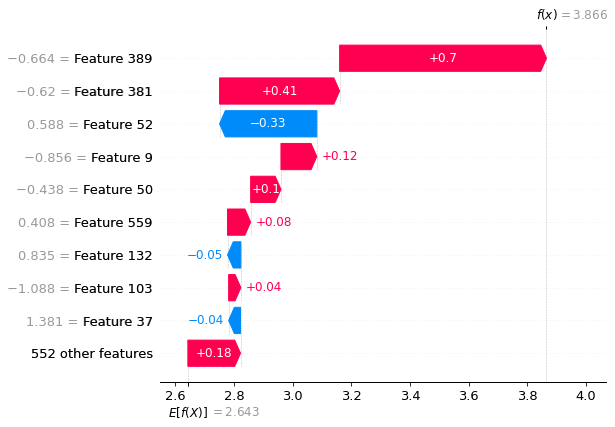

In [97]:
import shap  # noqa: F401
BestTrial = {'lambda': 1.2371893493010069e-05, 'alpha': 2.4703175098601867e-08}
# train an XGBoost model
model = xgb.XGBRegressor(**BestTrial).fit(X_train, y_train)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

# YOUR CODE HERE

### Conclusion

Your thoughts about the plots and model behaviour:

...